<a href="https://colab.research.google.com/github/eunices/pytorch-challenge/blob/master/Image_Classifier_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

!pip install pydrive
!pip install oauth2client

!pip install Pillow==4.0.0
!pip install PIL
!pip install image

  Using cached https://files.pythonhosted.org/packages/37/e8/b3fbf87b0188d22246678f8cd61e23e31caa1769ebc06f1664e2e5fe8a17/Pillow-4.0.0-cp36-cp36m-manylinux1_x86_64.whl
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


In [0]:
from collections import Counter, OrderedDict
from datetime import datetime as dt
from PIL import Image
from torch import nn, optim
from torchvision import (models, transforms, datasets)
import json
import matplotlib.pyplot as plt
import numpy as np
import random
import string
import torch
import torch.nn.functional as F
import torch.utils.data as data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# src = drive.CreateFile({'id':'1UQNEQIX6Ghvp3X2PopzU553MRw4HTUq4'})
# src.GetContentFile('train.py')

# import train

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [0]:
def load_data(folder_path, train_batch_size=5, valid_batch_size=5):
    """Loads from data folder. Returns test and train dataloader iterables."""
    # Params
    train_dir = folder_path + '/train'
    valid_dir = folder_path + '/valid'
    img_dim = 224
    normalize_mean = [0.485, 0.456, 0.406]
    normalize_std = [0.229, 0.224, 0.225]

    # Define your transforms for the training and validation sets
    data_transforms = {'train':
                       transforms.Compose([
                           transforms.RandomRotation(degrees=45),
                           transforms.RandomResizedCrop(
                               img_dim, scale=(0.8, 1.3)),
                           transforms.RandomHorizontalFlip(),
                           transforms.RandomVerticalFlip(),
                           transforms.ToTensor(),
                           transforms.Normalize(
                               mean=normalize_mean, std=normalize_std)
                       ]),
                       'valid':
                       transforms.Compose([
                           transforms.Resize(img_dim),
                           transforms.CenterCrop((img_dim, img_dim)),
                           transforms.ToTensor(),
                           transforms.Normalize(
                               mean=normalize_mean, std=normalize_std)
                       ])
                       }

    # Load the datasets with ImageFolder
    image_datasets_train = datasets.ImageFolder(
        root=train_dir, transform=data_transforms['train'])
    image_datasets_valid = datasets.ImageFolder(
        root=valid_dir, transform=data_transforms['valid'])

    print(f'{dt.now()} Loading images now.')
    # Using the image datasets and the trainforms, define the dataloaders
    dataloaders_train = data.DataLoader(image_datasets_train,
                                        batch_size=train_batch_size,
                                        shuffle=True,
                                        num_workers=4)
    dataloaders_valid = data.DataLoader(image_datasets_valid,
                                        batch_size=valid_batch_size,
                                        shuffle=True,
                                        num_workers=4)

    # Get number of classes
    class_counter = dict(Counter(img[1] for img in image_datasets_train.imgs))
    classes = len(class_counter)
    print(f'Number of classes in training data: {classes}')
    print(f'Total number of training examples: {sum(class_counter.values())}')
    
    class_to_idx = image_datasets_train.class_to_idx

    return dataloaders_train, dataloaders_valid, class_to_idx, classes

In [0]:
root = '/content/drive/My Drive/!!pytorch-challenge/pytorch_challenge'
data_dir = f'{root}/data/flower_data'
dataloaders_train, dataloaders_valid, class_to_idx, classes = load_data(data_dir, 128, 64)

2018-12-13 17:57:25.652763 Loading images now.
Number of classes in training data: 102
Total number of training examples: 6552


In [0]:
dataiter_train = iter(dataloaders_train)
images_train, label_train = dataiter_train.next()
dataiter_valid = iter(dataloaders_valid)
images_valid, label_valid = dataiter_valid.next()

In [0]:
print(images_train.shape)
print(images_train[0].numpy().transpose((1, 2, 0)).shape)

torch.Size([128, 3, 224, 224])
(224, 224, 3)


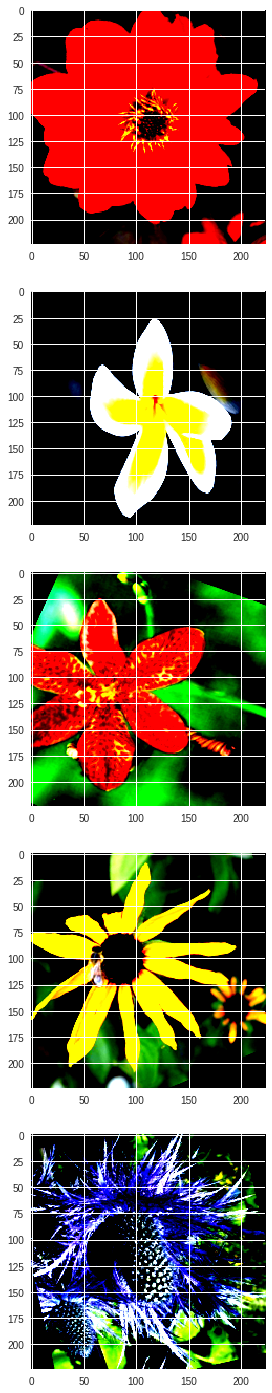

In [0]:
fig, ax = plt.subplots(nrows=len(images_train[0:5]), figsize=(5, 5*len(images_train[0:5])))
for i in range(0, len(images_train[0:5])):
    ax[i].imshow(images_train[i].numpy().transpose((1, 2, 0)).clip(0, 1))

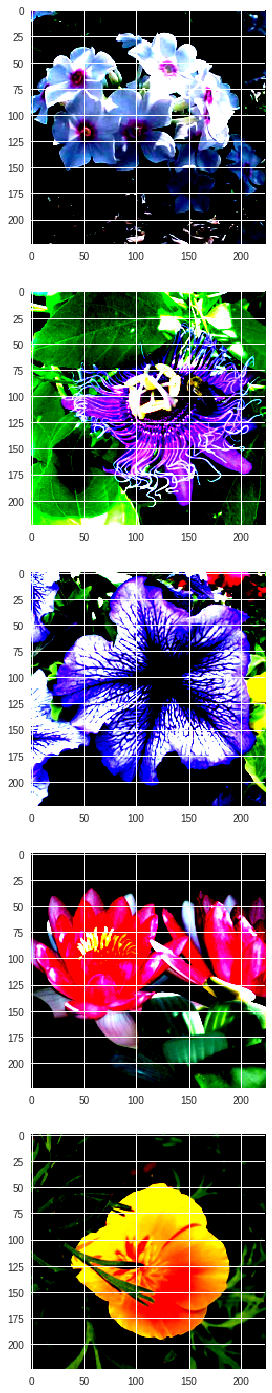

In [0]:
fig, ax = plt.subplots(nrows=len(images_valid[0:5]), figsize=(5, 5*len(images_valid[0:5])))
for i in range(0, len(images_valid[0:5])):
    ax[i].imshow(images_valid[i].numpy().transpose((1, 2, 0)).clip(0, 1))

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [0]:
def load_dictionary(filepath):
    """Load data dictionary."""
    with open(f'{filepath}/cat_to_name.json', 'r') as f:
        cat_to_name = json.load(f)
    return cat_to_name

In [0]:
cat_to_name = load_dictionary(root)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [0]:
DROPOUT = 0.5
LEARNING_RATE = 0.001
HIDDEN_UNITS_LI = [80, 90, 80]
TRAINING_EPOCHES = 8
OUTPUT_CLASSES = 102

INITIAL_UNITS = {
    'vgg16': 25088,
    'densenet121': 1024,
    'alexnet': 9216
}


def init_model(cnn_arch=list(INITIAL_UNITS.keys())[0],
               dropout=DROPOUT,
               hidden_units_li=HIDDEN_UNITS_LI,
               output_classes=OUTPUT_CLASSES,
               lr=LEARNING_RATE):
    """Initializes CNN. Returns model, criterion and optimizer"""
    # Initialize the model

    if cnn_arch == 'vgg16':
        model = models.vgg16(pretrained=True)
    else:
        model = ''
        print(f'Architecture not listed in {INITIAL_UNITS.keys()}')

    # Freeze params
    try:
        for param in model.parameters():
            param.requires_grad = False
    except AttributeError:
        raise
    except Exception as e:
        print(f'Error encountered: {e}')
        raise

    h_l = len(hidden_units_li)

    li = []
    for i in range(0, h_l-1):
        li.append((f'hidden_layer{i}', nn.Linear(
            hidden_units_li[i], hidden_units_li[i+1])))
        li.append((f'relu{i+2}', nn.ReLU()))

    # Replace the classifier
    classifier = nn.Sequential(
        OrderedDict(
            [('dropout', nn.Dropout(dropout)),
             ('inputs', nn.Linear(
                 INITIAL_UNITS[cnn_arch], hidden_units_li[0])),
             ('relu1', nn.ReLU())] +
            li +
            [('hidden_layer3', nn.Linear(hidden_units_li[h_l-1], output_classes)),
             ('output', nn.LogSoftmax(dim=1))]
        )
    )

    model.classifier = classifier

    if torch.cuda.is_available():
        model.cuda()

    # Initialize criterion and optimizer
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr)

    return model, criterion, optimizer

In [0]:
model, criterion, optimizer = init_model(output_classes=classes)

In [0]:
def train_model(model,
                criterion,
                optimizer,
                train_dataloader,
                valid_dataloader,
                epochs=TRAINING_EPOCHES):
    """Trains the CNN model. Prints the loss through the epochs."""

    # Params
    print_every_step = 10

    # Initialize
    running_loss = 0
    check_cuda = torch.cuda.is_available()

    print(f'{dt.now()} Model training has started.')

    # Start training
    for epoch in range(epochs):
        running_loss = 0
        for step, (train_images, train_labels) in enumerate(train_dataloader):

            # Move to cuda if GPU is used
            if check_cuda:
                train_images, train_labels = train_images.to(
                    'cuda'), train_labels.to('cuda')

            # Reset gradient for training
            optimizer.zero_grad()

            # Forward propagation
            train_logps = model.forward(train_images)
            train_loss = criterion(train_logps, train_labels)
            running_loss += train_loss.item()
            # loss is a Tensor w shape (1,), .item() get scalar

            # Backward propagation
            train_loss.backward()

            # Step forward
            optimizer.step()

            if step % print_every_step == 0:
                model.eval()  # To evaluation mode
                valid_loss = 0
                accuracy = 0

                # At every print step, we evaluate the model
                for _, (valid_images, valid_labels) in enumerate(valid_dataloader):
                    optimizer.zero_grad()

                    if check_cuda:
                        valid_images, valid_labels = \
                            valid_images.to('cuda'), valid_labels.to('cuda')
                        model.to('cuda')

                    valid_logps = model.forward(valid_images)
                    loss = criterion(valid_logps, valid_labels)
                    valid_loss += loss.item()

                    # Calculate accuracy
                    probabilities = torch.exp(valid_logps)
                    _, top_classes = probabilities.topk(1, dim=1)
                    prop_accurate_labels = \
                        top_classes == valid_labels.view(*top_classes.shape)
                    accuracy += torch.mean(
                        prop_accurate_labels.type(torch.FloatTensor)).item()

                # Print
                validation_size = len(valid_dataloader)
                print(f'{dt.now()} Epoch {epoch+1}/{epochs}..'
                      f'Train loss: {running_loss/print_every_step: .3f}..'
                      f'Validation loss: {valid_loss/validation_size: .3f}..'
                      f'Validation accuracy: {accuracy/validation_size: .3f}..')

                # Reset
                running_loss = 0

                # Back to training mode
                model.train()

    print(f'{dt.now()} Model training has ended.')

In [0]:
train_model(model, criterion, optimizer, dataloaders_train, dataloaders_valid)

2018-12-13 17:30:38.812353 Model training has started.
2018-12-13 17:31:05.665247 Epoch 1/8..Train loss:  0.464..Validation loss:  4.610..Validation accuracy:  0.012..
2018-12-13 17:31:37.843263 Epoch 1/8..Train loss:  4.506..Validation loss:  4.314..Validation accuracy:  0.082..
2018-12-13 17:32:09.876047 Epoch 1/8..Train loss:  4.141..Validation loss:  3.809..Validation accuracy:  0.211..
2018-12-13 17:32:41.913387 Epoch 1/8..Train loss:  3.622..Validation loss:  3.296..Validation accuracy:  0.282..
2018-12-13 17:33:13.897041 Epoch 1/8..Train loss:  3.129..Validation loss:  2.712..Validation accuracy:  0.374..
2018-12-13 17:33:39.298258 Epoch 1/8..Train loss:  2.676..Validation loss:  2.216..Validation accuracy:  0.472..
2018-12-13 17:34:06.521282 Epoch 2/8..Train loss:  0.230..Validation loss:  2.164..Validation accuracy:  0.465..
2018-12-13 17:34:38.800296 Epoch 2/8..Train loss:  2.040..Validation loss:  1.748..Validation accuracy:  0.571..
2018-12-13 17:35:11.095785 Epoch 2/8..Tra

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [0]:
MODEL_FILEPATH = root

def save_model(model, cnn_arch, hidden_units_li, dropout, learning_rate, output_classes, class_to_idx,
               filepath=MODEL_FILEPATH):
    """Saves model parameters to path."""
    model.cpu()

    idx_to_class = {v: k for k, v in class_to_idx.items()}

    checkpoint = {
        'idx_to_class': idx_to_class,
        'output_classes': output_classes,
        'cnn_arch': cnn_arch,
        'hidden_units_li': hidden_units_li,
        'dropout': dropout,
        'learning_rate': learning_rate,
        'state_dict': model.state_dict(),
    }
    filename = construct_model_filename()
    torch.save(checkpoint, f'{filepath}/{filename}')
    print(f'Model saved at {filepath}/{filename}')
    return filename
    

def construct_model_filename():
    """Construct an identifier for modelling dataframe (mdf).

    Includes name includes "mdf_", date created and 6 alphanumeric str.
    """
    random_string = create_random_six_chars()
    todays_date = dt.now().strftime("%Y-%m-%d")
    return f'model_{todays_date}_{random_string}.pth'


def create_random_six_chars():
    """Generate random 6 characters."""
    random_chars = 6
    random_string = ''.join(random.SystemRandom().choice(string.ascii_uppercase + string.digits)
                            for _ in range(random_chars))
    return random_string

In [0]:
filename = save_model(model, 'vgg16', HIDDEN_UNITS_LI, DROPOUT, LEARNING_RATE, OUTPUT_CLASSES, class_to_idx)

Model saved at /content/drive/My Drive/!!pytorch-challenge/pytorch_challenge/model_2018-12-13_TG7HJT.pth


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [0]:
def load_model(filename, filepath=MODEL_FILEPATH):
    """Loads a model checkpoint."""
    print(f'Loading model from {filepath}/{filename}')
    ckpt = torch.load(f'{filepath}/{filename}')

    print(f'Model loaded.')
    print(ckpt.keys())

    # Initialize model
    model, _, _ = init_model(ckpt['cnn_arch'],
                             ckpt['dropout'],
                             ckpt['hidden_units_li'],
                             ckpt['output_classes'],
                             ckpt['learning_rate'])

    # Initialize class_to_idx and weights
    model.idx_to_class = ckpt['idx_to_class']
    model.load_state_dict(ckpt['state_dict'])

    return model

In [0]:
model2 = load_model(filename)

Loading model from /content/drive/My Drive/!!pytorch-challenge/pytorch_challenge/model_2018-12-13_TG7HJT.pth
Model loaded.
dict_keys(['idx_to_class', 'output_classes', 'cnn_arch', 'hidden_units_li', 'dropout', 'learning_rate', 'state_dict'])


In [0]:
model.classifier

Sequential(
  (dropout): Dropout(p=0.5)
  (inputs): Linear(in_features=25088, out_features=80, bias=True)
  (relu1): ReLU()
  (hidden_layer0): Linear(in_features=80, out_features=90, bias=True)
  (relu2): ReLU()
  (hidden_layer1): Linear(in_features=90, out_features=80, bias=True)
  (relu3): ReLU()
  (hidden_layer3): Linear(in_features=80, out_features=102, bias=True)
  (output): LogSoftmax()
)

In [0]:
model2.classifier

Sequential(
  (dropout): Dropout(p=0.5)
  (inputs): Linear(in_features=25088, out_features=80, bias=True)
  (relu1): ReLU()
  (hidden_layer0): Linear(in_features=80, out_features=90, bias=True)
  (relu2): ReLU()
  (hidden_layer1): Linear(in_features=90, out_features=80, bias=True)
  (relu3): ReLU()
  (hidden_layer3): Linear(in_features=80, out_features=102, bias=True)
  (output): LogSoftmax()
)

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typi
cally encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # configs
    basewidth = 224
    colors = 255
    
    # centre crop and resize
    width, height = image.size   
    new_width = new_height = min(width, height)

    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2

    image = image.crop((left, top, right, bottom)).resize((basewidth, basewidth))

    # convert to array
    img_arr = np.array(image)

    # normalize by to 0 and 1
    img_arr = img_arr / float(colors)

    # normalize by specific method
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_arr = (img_arr - mean) / std

    # rearrange
    return torch.tensor(img_arr.transpose((2, 0, 1)))

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

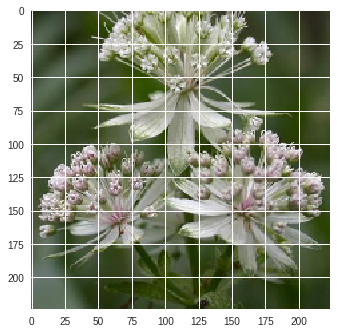

In [0]:
img_path = f'{root}/data/flower_data/train/38/image_05794.jpg'
flower = Image.open(img_path)
imshow(process_image(flower))

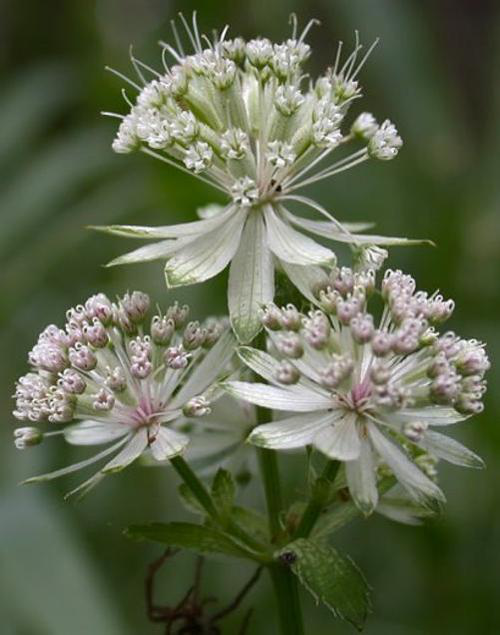

In [0]:
flower

In [0]:
img_tensor = process_image(flower)
img_tensor.shape

torch.Size([3, 224, 224])

In [0]:
img_tensor2 = img_tensor.unsqueeze_(0)
img_tensor2.shape

torch.Size([1, 3, 224, 224])

In [0]:
img_tensor3 = img_tensor2.float()
img_tensor3.shape

torch.Size([1, 3, 224, 224])

In [0]:
print(images_train.shape)
print(images_train[0].numpy().transpose((1, 2, 0)).shape)

torch.Size([128, 3, 224, 224])
(224, 224, 3)


## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [0]:
def predict_image(filepath, model, topk):
    """Make prediction for an image."""
    # Open and preprocess image
    image = Image.open(filepath)
    img_tensor = process_image(image)
    img_tensor = img_tensor.unsqueeze_(0).float()
    
    print(f'Tensor shape: {img_tensor.shape}')
    
    # Forward pass with CNN
    with torch.no_grad():
        if torch.cuda.is_available():
            model.cuda()
            output = model.forward(img_tensor.cuda())
        else:
            output = model.forward(img_tensor)

    probability = torch.exp(output)
    top_probabilities, top_classes = probability.topk(topk, dim=1)

    # convert probs and classes to list
    top_probabilities = list(top_probabilities.cpu().numpy()[0])
    top_classes = list(top_classes.cpu().numpy()[0])
    top_classes = [model.idx_to_class[x] for x in top_classes]

    return top_probabilities, top_classes

In [0]:
top_probabilities, top_classes = predict_image(img_path, model2, 5)

Tensor shape: torch.Size([1, 3, 224, 224])


In [0]:
top_probabilities

[0.99015534, 0.006387667, 0.0010980378, 0.0009232361, 0.00037194864]

In [0]:
top_classes

['38', '33', '22', '66', '55']

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [0]:
def plot_img_metrics(img_path, probs, classes, dictionary):
        
    # open/ preprocess image
    img = Image.open(img_path)
    img_processed = process_image(img).numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_processed = std * img_processed + mean
    img_processed = np.clip(img_processed, 0, 1)
    
    # preprocess
    max_prob_idx = probs.index(max(probs))   
    classes_num = [int(no) for no in classes]
    classes_name = [' '.join([x.capitalize() for x in dictionary[str(no)].split()]) for no in classes_num]
    
    # setup image
    yticks = np.arange(len(classes))
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
    
    # show flower image
    ax[0].imshow(img_processed)
    ax[0].set_title('Flower with highest likelihood - ' + classes_name[max_prob_idx])
    
    # show barchart with probabilities
    ax[1].barh(yticks, probs)
    ax[1].set_yticks(yticks)
    ax[1].set_yticklabels(classes_name)
    ax[1].invert_yaxis() 
    ax[1].set_title('Probabilities')

    fig.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


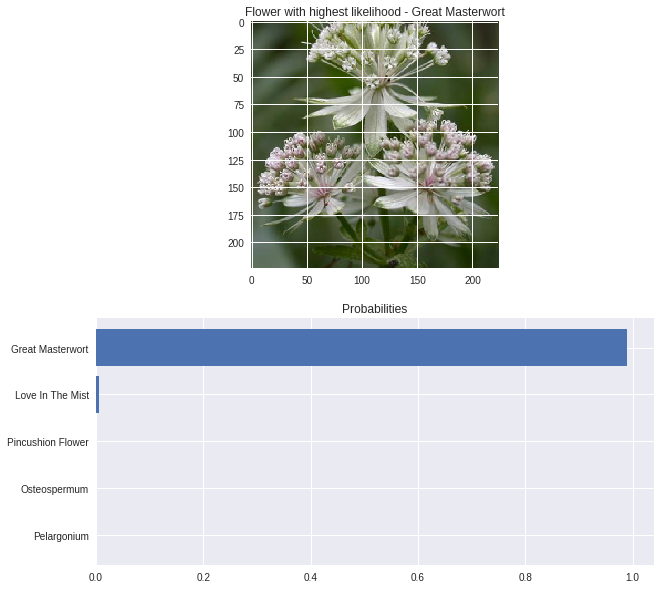

In [0]:
plot_img_metrics(img_path, top_probabilities, top_classes, cat_to_name)

In [0]:
cat_to_name

{'1': 'pink primrose',
 '10': 'globe thistle',
 '100': 'blanket flower',
 '101': 'trumpet creeper',
 '102': 'blackberry lily',
 '11': 'snapdragon',
 '12': "colt's foot",
 '13': 'king protea',
 '14': 'spear thistle',
 '15': 'yellow iris',
 '16': 'globe-flower',
 '17': 'purple coneflower',
 '18': 'peruvian lily',
 '19': 'balloon flower',
 '2': 'hard-leaved pocket orchid',
 '20': 'giant white arum lily',
 '21': 'fire lily',
 '22': 'pincushion flower',
 '23': 'fritillary',
 '24': 'red ginger',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '27': 'prince of wales feathers',
 '28': 'stemless gentian',
 '29': 'artichoke',
 '3': 'canterbury bells',
 '30': 'sweet william',
 '31': 'carnation',
 '32': 'garden phlox',
 '33': 'love in the mist',
 '34': 'mexican aster',
 '35': 'alpine sea holly',
 '36': 'ruby-lipped cattleya',
 '37': 'cape flower',
 '38': 'great masterwort',
 '39': 'siam tulip',
 '4': 'sweet pea',
 '40': 'lenten rose',
 '41': 'barbeton daisy',
 '42': 'daffodil',
 '43': 'sword lily',